### Facsimile inversion 

In [1]:
import numpy as np
import itertools as it
from utils import iterative_solve_eta as itsol
import matplotlib.pyplot as plt
from scipy.special import softmax

In [2]:
print(np.version.version)

1.23.5


In [3]:
clip = lambda x, l, u: l if x < l else u if x > u else x

def solve_eta(pi, PObs_lim, gamma, rho0, Lx, Ly, Lx0, Ly0, find_range):
    """
    This function should solve the following:
    --> New_eta = (1 - gamma T)^-1 rho
    """
    

    O, M, A = pi.shape
    L = Lx * Ly
    new_eta = np.zeros(M*L)
    
    # PY has size ~ 10^5
    PY = PObs_lim.reshape(O, M, Ly, Lx)
    # PY has size ~ 10^2
    PAMU = pi.reshape(O, M, M, A//M)
    
    p_a_mu_m_xy = np.einsum( 'omyx, omna -> anmyx', PY, PAMU)
    # T [ s'm'  sm] = sum_a, mu p(s'm' | sm a mu) p(a mu | sm)
    #               = sum_a, mu p(s'm' | sm a mu) sum_y f(y | s) pi(a mu | y m)
    
    print(p_a_mu_m_xy.shape)
    
    # Tsm_sm has size ~ 10^5 x 10^5 or more
    Tsm_sm = np.zeros( (M, Ly, Lx, M, Ly, Lx) )
    
    # Action Order
    # left, right, up, down
    
    # tuples to be populated
    #      T indices : "left / right / up / down"
    #      (m', y', x', m, y, x)
    #      pi indices : "left_act / ... "
    #      (m', a, m, y, x)
    for im_new in range(M):
        
        left = [ (im_new, iy, clip(ix-1, 0, Lx-1), im, iy, ix)   for ix in np.arange(Lx) for iy in np.arange(Ly) for im in np.arange(M)]
        left_act = [ (0, im_new, im, iy, ix)   for ix in np.arange(Lx) for iy in np.arange(Ly) for im in np.arange(M)]
        
        for l, la in zip(left, left_act):
            Tsm_sm[l] += p_a_mu_m_xy[la]
        
        right = [ (im_new, iy, clip(ix+1, 0, Lx-1), im, iy, ix)   for ix in np.arange(Lx) for iy in np.arange(Ly) for im in np.arange(M)]
        right_act = [ (1, im_new, im, iy, ix)   for ix in np.arange(Lx) for iy in np.arange(Ly) for im in np.arange(M)]
        for r, ra in zip(right, right_act):
            Tsm_sm[r] += p_a_mu_m_xy[ra]
    
        up = [ (im_new, clip(iy+1, 0, Ly-1), ix,  im, iy, ix)   for ix in np.arange(Lx) for iy in np.arange(Ly) for im in np.arange(M)]
        up_act = [ (2, im_new, im, iy, ix)   for ix in np.arange(Lx) for iy in np.arange(Ly) for im in np.arange(M)]
        for u, ua in zip(up, up_act):
            Tsm_sm[u] += p_a_mu_m_xy[ua]
        
        down = [ (im_new, clip(iy-1, 0, Ly-1), ix, im, iy, ix)   for ix in np.arange(Lx) for iy in np.arange(Ly) for im in np.arange(M)]
        down_act = [ (3, im_new, im, iy, ix)   for ix in np.arange(Lx) for iy in np.arange(Ly) for im in np.arange(M)]
        for d, da in zip(down, down_act):
            Tsm_sm[d] += p_a_mu_m_xy[da]
    
    yxs = it.product(np.arange(Ly), np.arange(Lx))
    yx_founds = it.filterfalse(lambda x: (x[0]-Ly0)**2 + (x[1]-Lx0)**2 > find_range**2, yxs)
    print(type(yx_founds))
    
    All = slice(None)
    for yx_found in yx_founds:
        ls = (All, yx_found[0], yx_found[1], All, All, All)
        print(ls)
        print(yx_found)
        # all transitions starting from the source do not go anywhere
        Tsm_sm[ls] = 0
        # all transitions ending in the source stop the episode
        ls = (All, All, All, All, yx_found[0], yx_found[1])
        Tsm_sm[ls] = 0
        print(yx_found)
    
    Tsm_sm_matrix = np.reshape(Tsm_sm, (M*Ly*Lx, M*Ly*Lx))
    to_invert = np.eye(M*Ly*Lx) - gamma * Tsm_sm_matrix
    inverted = np.linalg.inv(to_invert)
    new_eta = inverted @ rho0
    
    return new_eta, Tsm_sm_matrix

## TEST

(4, 2, 2, 15, 11)
<class 'itertools.filterfalse'>
(slice(None, None, None), 5, 5, slice(None, None, None), slice(None, None, None), slice(None, None, None))
(5, 5)
(5, 5)
(slice(None, None, None), 6, 4, slice(None, None, None), slice(None, None, None), slice(None, None, None))
(6, 4)
(6, 4)
(slice(None, None, None), 6, 5, slice(None, None, None), slice(None, None, None), slice(None, None, None))
(6, 5)
(6, 5)
(slice(None, None, None), 6, 6, slice(None, None, None), slice(None, None, None), slice(None, None, None))
(6, 6)
(6, 6)
(slice(None, None, None), 7, 3, slice(None, None, None), slice(None, None, None), slice(None, None, None))
(7, 3)
(7, 3)
(slice(None, None, None), 7, 4, slice(None, None, None), slice(None, None, None), slice(None, None, None))
(7, 4)
(7, 4)
(slice(None, None, None), 7, 5, slice(None, None, None), slice(None, None, None), slice(None, None, None))
(7, 5)
(7, 5)
(slice(None, None, None), 7, 6, slice(None, None, None), slice(None, None, None), slice(None, None, Non

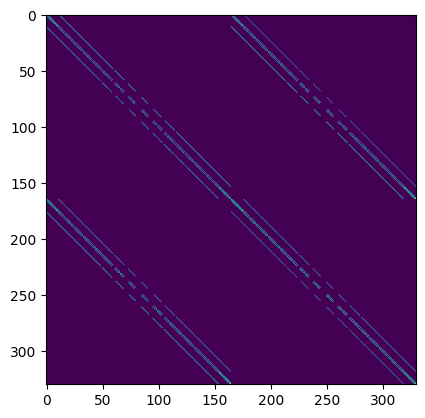

In [4]:
M = 2
O = 2
Lx = 11
Ly = 15
a_size = 4

pi = softmax( np.random.rand(O,M,M*a_size), 2)

PObs_lim = np.random.rand(O, M*Lx*Ly)
PObs_lim[1] = 1-PObs_lim[0]
Lx0 = 5
Ly0 = 7
rho0 = np.random.rand(M*Lx*Ly)
rho0[Lx:] = 0
rho0 /= np.sum(rho0)
eta0 = np.random.rand(M*Lx*Ly)
gamma = 0.99
find_range = 2.1
tol = 1e-8

inv_sol, T = solve_eta(pi, PObs_lim, gamma, rho0, Lx, Ly, Lx0, Ly0, find_range)
iter_sol = itsol(pi, PObs_lim, gamma, rho0, eta0, tol, Lx, Ly, Lx0, Ly0, find_range)

plt.imshow(T)

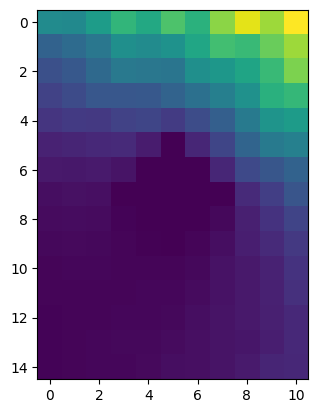

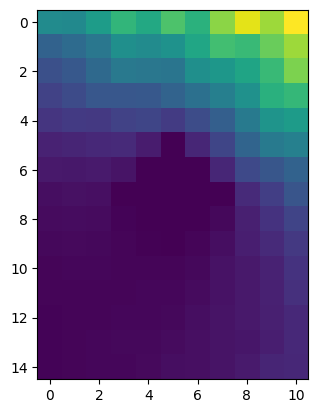

5.5523219537625956e-05

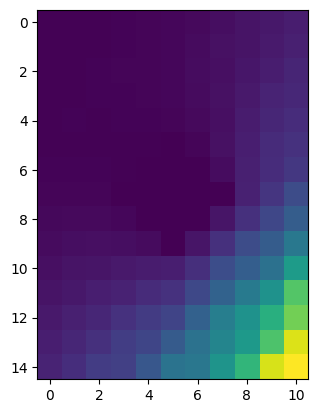

In [5]:
plt.imshow(inv_sol.reshape(M,Ly,Lx)[0])
plt.show()
plt.imshow(iter_sol.reshape(M,Ly,Lx)[0])
plt.show()
plt.imshow(np.abs(iter_sol.reshape(M,Ly,Lx)[0]-inv_sol.reshape(M,Ly,Lx)[0]))
np.abs(iter_sol.reshape(M,Ly,Lx)[0]-inv_sol.reshape(M,Ly,Lx)[0]).max()